## Feedforward Neural Networks - MNIST Dataset

In [1]:
from Plot import plot_image_grid
import torchvision.transforms as transforms    
import torchvision.datasets as datasets        
from torch.utils.data import DataLoader         
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/anaconda3/envs/M1/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/M1/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c1017RegisterOperatorsD1Ev)
  Referenced from: '/opt/anaconda3/envs/M1/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/opt/anaconda3/envs/M1/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 🍳 Data Preparation

We'll be training on the MNIST dataset which has 60K images of handwritten numbers ranging from 0 to 9.

In [ ]:
batch_size = 100

# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader: To be converted to batched of shape [100, 1, 28, 28]
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

plot_image_grid(train_dataset)

## 🚢 Model Building

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        
        # Architecture
        self.layers= nn.Sequential(
        nn.Flatten(),                                       # Flattening the 28x28 image into a 784 vector
        nn.Linear(input_size, hidden_size), nn.Dropout(p=0.0), nn.ReLU(),                          
        nn.Linear(hidden_size, output_size)                 # Ask yourself, why?
        )

        # Loss Function
        self.criterion = nn.CrossEntropyLoss()
        
        # Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.002)

    
    def forward(self, x):
        logits = self.layers(x)
        return logits   

In [4]:
input_size, hidden_size, num_classes = 784, 500, 10
model = NeuralNet(input_size, hidden_size, num_classes).to(device)   
model

NeuralNet(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

## 💪 Model Training

In [5]:
from tqdm.notebook import tqdm

NUM_EPOCHS = 3
num_batches = len(train_loader)
with tqdm(range(NUM_EPOCHS), desc="Epochs") as epoch_bar:
    for epoch in epoch_bar:
        total_loss, num_correct = 0.0, 0
        for i, (xb, yb) in enumerate(train_loader):
            
            # 0. Move to GPU
            xb, yb = xb.to(device), yb.to(device)
            if i == 0: assert xb.shape == (batch_size, 1, 28, 28)
            
            # 1. Forward pass
            ŷb = model(xb)
            if i == 0: assert ŷb.shape == (batch_size, 10)
            loss = model.criterion(ŷb, yb)

            # 2. Backward pass
            loss.backward()
            
            # 3. Optimization step
            model.optimizer.step()
            model.optimizer.zero_grad()

            # 4. Statistics:
            total_loss += loss.item()
            ŷb = ŷb.argmax(dim=1)
            num_correct += (ŷb == yb).sum().item()
         
        # 5. Logging:
        loss = total_loss / num_batches
        accuracy = num_correct / (num_batches * train_loader.batch_size)
        epoch_bar.set_postfix(loss=loss, accuracy = accuracy)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

## 🕵️ Evaluation

Let's loop and test all validation data:

In [6]:
with torch.no_grad():
    num_correct = 0
    for xb, yb in val_loader:
        # 0. Move to GPU
        xb, yb = xb.to(device), yb.to(device)
        # 1. Forward pass
        ŷb = model(xb)                       # (batch_size, num_classes)
        # 2. Statistics 
        ŷb = ŷb.argmax(1)      
        num_correct += (ŷb == yb).sum().item()

    acc = 100.0 * num_correct / len(val_dataset)
    print(f'Accuracy: {acc} %')

Accuracy: 97.76 %


### 💻 Deployment

In [7]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model
loaded_model = NeuralNet(input_size, hidden_size, num_classes).to(device)   
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model = loaded_model.to(device)
loaded_model.eval()

NeuralNet(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

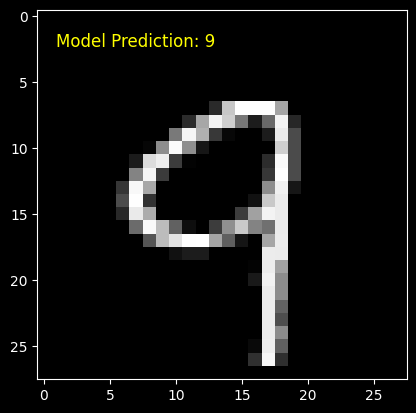

In [14]:
rand_num = torch.randint(0, 10000, (1,)).item()
rand_val_img, _ = val_dataset[rand_num]
plt.imshow(rand_val_img[0], cmap='gray')
prediction = loaded_model(rand_val_img.to(device).unsqueeze(0)).argmax(dim=1).item()
plt.text(0.05, 0.9, f'Model Prediction: {prediction}', color="yellow", transform=plt.gca().transAxes, fontsize=12)
plt.show()